Nama : Mario Adi Nugroho
username : mrbongs
linkedin : https://www.linkedin.com/in/marioadii/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

# Collection of Data

In [68]:
# untuk nama directory file
train_dir = '/content/drive/MyDrive/dicoding classification'

#untuk penamaan folder
paper_path = "/content/drive/MyDrive/dicoding classification/paper"
rock_path = "/content/drive/MyDrive/dicoding classification/rock"
scissors_path = "/content/drive/MyDrive/dicoding classification/scissors"

In [49]:
labels = ['paper','scissors','rock']
nb = len(labels)

# Membagi Gambar dan Label

In [53]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def input_target_split(train_dir, labels):
    dataset = []
    count = 0
    for label in labels:
        folder = os.path.join(train_dir, label)
        for image in os.listdir(folder):
            img = load_img(os.path.join(folder, image), target_size=(150, 150))
            img = img_to_array(img)
            img = img / 255.0
            dataset.append((img, count))
        print(f'\rCompleted: {label}', end='')
        count += 1
    random.shuffle(dataset)
    X, y = zip(*dataset)

    return np.array(X), np.array(y)

# Example usage
train_dir = '/content/drive/MyDrive/dicoding classification'
labels = ['paper', 'rock', 'scissors']  # Ensure this list is defined
X, y = input_target_split(train_dir, labels)

Completed: scissors

# Visualisasi data

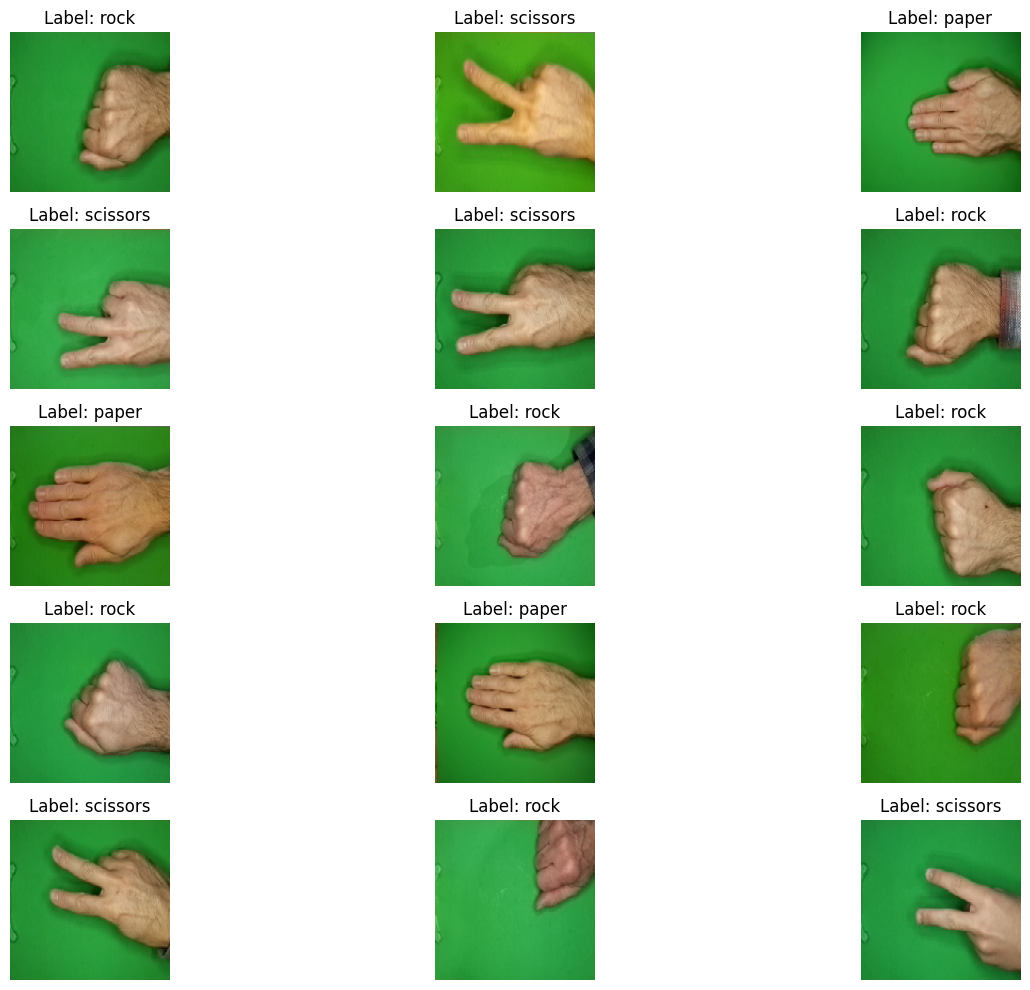

Label Distribution: (array([0, 1, 2]), array([712, 726, 750]))


In [54]:
import matplotlib.pyplot as plt

# Function to display images in a grid
def display_image_grid(X, y, labels, nrows=5, ncols=3):
    plt.figure(figsize=(15, 10))

    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(X[i])
        label_index = y[i]
        plt.title(f'Label: {labels[label_index]}')
        plt.axis('off')  # Hide the axis to make images more clear

    plt.tight_layout()  # Adjust the layout to fit everything nicely
    plt.show()

# Example usage
display_image_grid(X, y, labels)

# Check the distribution of labels
label_counts = np.unique(y, return_counts=True)
print("Label Distribution:", label_counts)

# Splitting the images and labels into training and test set

In [55]:
# Splitting the dataset into training and validation sets
from sklearn.model_selection import train_test_split
validation_size = 0.40  # 40% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size, random_state=42)

# Print out the sizes of each dataset
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))

Training set size: 1312
Validation set size: 876


# Menerapkan Teknik Augmentasi Data

In [56]:
# Data augmentation for training data
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.1,
                             fill_mode="nearest")

# Data generator for validation data (usually no data augmentation)
testgen = ImageDataGenerator()

# Fitting the data generators
# Note: You should fit the ImageDataGenerator only on the training data, not on the validation or test data.
datagen.fit(X_train)

In [57]:
import numpy as np

# Set the number of classes
nb = len(labels)  # This should be 3 in your case

# Ensure y_train and y_val are numpy arrays of type int
y_train = np.array(y_train, dtype=int)
y_val = np.array(y_val, dtype=int)

# One-hot encoding
y_train_onehot = np.eye(nb)[y_train]
y_val_onehot = np.eye(nb)[y_val]

# Check the shape of the one-hot encoded arrays
print("Shape of y_train_onehot:", y_train_onehot.shape)
print("Shape of y_val_onehot:", y_val_onehot.shape)

Shape of y_train_onehot: (1312, 3)
Shape of y_val_onehot: (876, 3)


# Modeling Using CNN

In [58]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # Output layer for 3 classes
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [59]:
# Train the Model
history = model.fit(datagen.flow(X_train, y_train_onehot, batch_size=32),
                    validation_data=(X_val, y_val_onehot),
                    steps_per_epoch=len(X_train) / 32, epochs=10)

# Evaluate the Model and Generate the Training History
history_dict = history.history

# Print out the model summary and the final accuracy for a quick check
model.summary()
final_accuracy = history_dict['val_accuracy'][-1]  # Final validation accuracy
print("Final Validation Accuracy: {:.2f}%".format(final_accuracy * 100))

Epoch 1/10
41/41 [==============================] - 130s 3s/step - loss: 1.0714 - accuracy: 0.4360 - val_loss: 0.8826 - val_accuracy: 0.7009
Epoch 2/10
41/41 [==============================] - 115s 3s/step - loss: 0.6619 - accuracy: 0.7370 - val_loss: 0.3112 - val_accuracy: 0.9521
Epoch 3/10
41/41 [==============================] - 117s 3s/step - loss: 0.4233 - accuracy: 0.8224 - val_loss: 0.2400 - val_accuracy: 0.9441
Epoch 4/10
41/41 [==============================] - 120s 3s/step - loss: 0.3117 - accuracy: 0.8941 - val_loss: 0.1617 - val_accuracy: 0.9589
Epoch 5/10
41/41 [==============================] - 122s 3s/step - loss: 0.2191 - accuracy: 0.9253 - val_loss: 0.1016 - val_accuracy: 0.9795
Epoch 6/10
41/41 [==============================] - 122s 3s/step - loss: 0.1630 - accuracy: 0.9474 - val_loss: 0.1046 - val_accuracy: 0.9749
Epoch 7/10
41/41 [==============================] - 115s 3s/step - loss: 0.1335 - accuracy: 0.9619 - val_loss: 0.0557 - val_accuracy: 0.9852
Epoch 8/10
41

# Mendefinisikan callback untuk model seperti EarlyStopping dan Best Model Pada CNN (Best Performance)


In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.callbacks import ReduceLROnPlateau  # Uncomment if you want to use this

# File path to save the model
filepath = "model_cnn_final.h5"

# Creating ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

# Creating EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

# Uncomment the following lines if you wish to use ReduceLROnPlateau
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
#                                             patience=3,
#                                             verbose=1,
#                                             factor=0.2,
#                                             min_lr=0.00001)

# Creating a list of callbacks
callbacks_list = [checkpoint, early_stopping
                  # , learning_rate_reduction  # Uncomment if using ReduceLROnPlateau
                 ]

# Now, you can use these callbacks in your model training
history = model.fit(datagen.flow(X_train, y_train_onehot, batch_size=32),
                    validation_data=(X_val, y_val_onehot),
                    steps_per_epoch=len(X_train) / 32, epochs=10,
                    callbacks=callbacks_list)

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9741
Epoch 1: val_accuracy improved from -inf to 0.97831, saving model to model_cnn_final.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 119s 3s/step - loss: 0.0936 - accuracy: 0.9741 - val_loss: 0.0676 - val_accuracy: 0.9783
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9665
Epoch 2: val_accuracy did not improve from 0.97831
41/41 [==============================] - 121s 3s/step - loss: 0.0956 - accuracy: 0.9665 - val_loss: 0.0684 - val_accuracy: 0.9715
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9619
Epoch 3: val_accuracy improved from 0.97831 to 0.98630, saving model to model_cnn_final.h5
41/41 [==============================] - 120s 3s/step - loss: 0.1310 - accuracy: 0.9619 - val_loss: 0.0503 - val_accuracy: 0.9863
Epoch 4/10
41/41 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9611
Epoch 4: val_accuracy improved from 0.98630 to 0.98858, saving model to model_cnn_final.h5
41/41 [==============================] - 118s 3s/step - loss: 0.1122 - accuracy: 0.9611 - val_l

# Prediction Image

Saving 0OEXfEooCXlljaEl.png to 0OEXfEooCXlljaEl.png


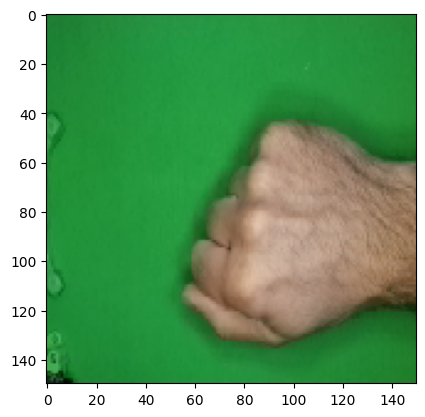

1/1 [==============================] - 0s 39ms/step
0OEXfEooCXlljaEl.png
rock


In [66]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# This is required in a Jupyter notebook, but not in a script in Colab
# %matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
    # Predicting images
    path = fn
    img = image.load_img(path, target_size=(150, 150))

    plt.imshow(img)
    plt.show()  # Display the image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=10)
    print(fn)
    # Assuming 'classes' will return a list of probabilities, we take the argmax to get the predicted class index
    if np.argmax(classes) == 0:
        print('paper')
    elif np.argmax(classes) == 1:
        print('rock')
    else:
        print('scissors')
